In [1]:
# Imports
from src import *
import scipy.sparse.linalg as spsl
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Algorithm Parameters
num_qubits = 10
max_energy_level = 4
kd_ratio = 2.5
noise_threshold = 1e-2
epsilon = 1e-3
K_values = list(range(0,300,1))
delta_t = 0.33
num_modmd_observables = 6
num_trials = 5

In [3]:
# Load Hamiltonian, get true eigenergies
with open('Data/Hamiltonians/LiH_equilibrium_hamiltonian.pkl', 'rb') as f:
    sparse_lih_hamiltonian = pickle.load(f)
eigenvalues = np.sort(spsl.eigsh(sparse_lih_hamiltonian,k=20,which = 'SA')[0])
true_eigenenergies = eigenvalues[[0,3,6,11,17]]

In [4]:
# Construct reference state
reference_state = bitstring_superposition_state(num_qubits, ['0000100001', '0000000011', '0001000001','0010100000'])

# Get evolved reference states
max_K = K_values[-1]
max_d = int(max_K/kd_ratio)
time_evolution_operator = -1j*sparse_lih_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=max_d+max_K+1,num = max_d+max_K+2)

In [5]:
# Get MODMD observables
with open('Data/Hamiltonians/LiH_pauli_representation.pkl', 'rb') as f:
    lih_pauli_coefficients, lih_pauli_strings = pickle.load(f)

sorted_pauli_observables = np.array(lih_pauli_strings)[np.argsort(np.abs(lih_pauli_coefficients))[::-1]]
modmd_observables = [SparsePauliOp(p).to_matrix(sparse=True) for p in sorted_pauli_observables[75:81]]

In [6]:
# ODMD Results
odmd_observables = [SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)]
odmd_results = []

X_elements = generate_X_elements(odmd_observables,max_d,max_K,reference_state,evolved_reference_states)

for trial in range(num_trials):

    print(f'Trial {trial+1}')
    
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    odmd_results.append(varying_K_results(len(odmd_observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [7]:
# MODMD Results
modmd_results = []

# X_elements = generate_X_elements(modmd_observables,max_d,max_K,reference_state,evolved_reference_states)
X_elements = generate_X_elements(modmd_observables,max_d,max_K,reference_state,evolved_reference_states)

for trial in range(num_trials):
    print(f'Trial {trial+1}')
    
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    modmd_results.append(varying_K_results(len(modmd_observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [8]:
# Compute errors
absolute_odmd_errors = np.array([np.abs(odmd_results[i] - true_eigenenergies) for i in range(num_trials)])
absolute_modmd_errors = np.array([np.abs(modmd_results[i] - true_eigenenergies) for i in range(num_trials)])

Text(0, 0.5, 'Absolute Error')

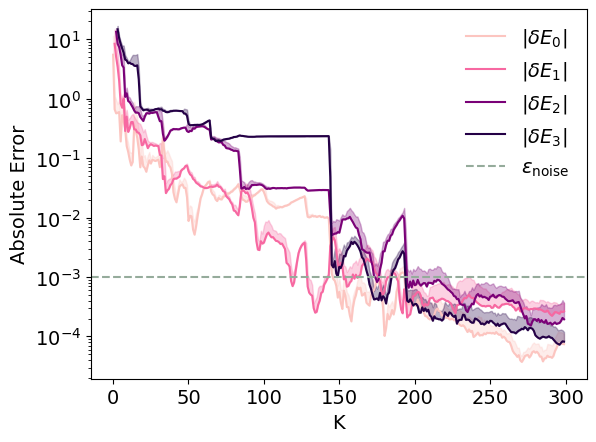

In [11]:
# Plotting
energy_levels = [0,1,2,3]
algorithm = 'MODMD'
colors = ['#fcc5c0','#f768a1','#7a0177', '#240046']
labels = [r'$|\delta E_0|$',r'$|\delta E_1|$',r'$|\delta E_2|$',r'$|\delta E_3|$']

for i, energy_level in enumerate(energy_levels):

    if algorithm == 'ODMD':
        odmd_average = np.average(absolute_odmd_errors,0)[:,energy_level]
        odmd_std = np.std(absolute_odmd_errors,0)[:,energy_level]
        plt.semilogy(K_values, odmd_average, '--', color = colors[i], label = labels[i])
        plt.fill_between(K_values,odmd_average,odmd_average + odmd_std,color = colors[i],alpha = .3)
        
    elif algorithm == 'MODMD':
        modmd_average = np.average(absolute_modmd_errors,0)[:,energy_level]
        modmd_std = np.std(absolute_modmd_errors,0)[:,energy_level]
        plt.semilogy(K_values,modmd_average,color = colors[i],label = labels[i])
        plt.fill_between(K_values,modmd_average,modmd_average + modmd_std,color = colors[i],alpha = .3)

matplotlib.rcParams.update({'font.size': 14})
plt.axhline(epsilon, color = '#95ab9b', linestyle = '--', label = r'$\epsilon_\text{noise}$')
plt.legend(framealpha = 0, fontsize=14)
plt.xlabel('K')
plt.ylabel(r'Absolute Error')